# Pre-Filtering for Gaussian Fitting

As discussed in the touch-extraction notebook, we can use a 2D Gaussian distribution to represent a touch point.
The coordinate of this point is given by its mean $\mu$, while the contact area, described by an ellipse, is derived from its covariance matrix $\Sigma$.

The usual caveat applies, however: This only ever works well if the data fits (at least somewhat) to our model.
We can expect this to be the case for finger tips (round-ish in shape, with a single local maximum), but in reality not only fingers will touch the screen.
When writing, for example, the palm will likely touch the screen.
When lifting the tablet, the hands might cause accidental touches at the side.
Both of which may (in case of writing quite likely) not match a Gaussian, e.g. be convex and have multiple local maximas in the same connected area.

Under these conditions, the previously explored Gaussian fitting approach will break down, leading to undesired inputs.
We could now try to extend the algorithm so that it might be able to handle arbitrary shapes, but that then directly begs the question of how one should parametrize arbitrary shapes.
This would also come with the problem of how one should attempt to solve for those parameters, especially considering that we deal with inherently noisy data, as it is likely that there is no closed form solution for this problem.
Thus we, for now, consider this problem ill-posed (since we don't have such a parametrization) and will focus on a different idea:
Pre-filtering the input data so that only Gaussian-like objects remain.

As always, let's start off with the required imports (and some basic configuration):

In [1]:
# enable local imports for libipts
import sys, os
sys.path.append(os.path.abspath('../utils'))

# imports
import libipts

import numpy as np
import scipy.ndimage
import scipy.signal
import diplib as dip

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse

import itertools

# config
%matplotlib notebook

plot_size = 3.2
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = (3 * plot_size, 2 * plot_size)

## Basic Concepts and Pre-Processing

We use Sobel operators to compute the gradient of the heatmap image.
So let's define the Sobel operator kernels in $x$- and $y$-direction for first derivatives (i.e. the gradient):

In [2]:
SOBEL_X = np.array([
    [1.0, 0.0, -1.0],
    [2.0, 0.0, -2.0],
    [1.0, 0.0, -1.0],
])

SOBEL_Y = SOBEL_X.T

These operators are based on central differences in the direction of which the gradient should be computed and a smoothing operator in direction orthogonal to that.
Similarly, we'll use the Sobel operator kernels for second derivatives to compute the Hessian:

In [3]:
SOBEL_XX = np.array([
    [1.0, -2.0, 1.0],
    [2.0, -4.0, 2.0],
    [1.0, -2.0, 1.0],
])

SOBEL_YY = SOBEL_XX.T

SOBEL_XY = np.array([
    [ 1.0, 0.0, -1.0],
    [ 0.0, 0.0,  0.0],
    [-1.0, 0.0,  1.0],
])

Note that, in contrast to the ones for the gradient, these are based on forward-/backward-differences.
We can, alternatively, also derive the the Sobel operator kernels for the Hessian via central differences:

In [4]:
SOBEL_XX_2 = np.array([
    [1.0, 0.0,  -2.0, 0.0, 1.0],
    [4.0, 0.0,  -8.0, 0.0, 4.0],
    [6.0, 0.0, -12.0, 0.0, 6.0],
    [4.0, 0.0,  -8.0, 0.0, 4.0],
    [1.0, 0.0,  -2.0, 0.0, 1.0],
])

SOBEL_YY_2 = SOBEL_XX_2.T

SOBEL_XY_2 = np.array([
    [ 1.0,  2.0, 0.0, -2.0, -1.0],
    [ 2.0,  4.0, 0.0, -4.0, -2.0],
    [ 0.0,  0.0, 0.0,  0.0,  0.0],
    [-2.0, -4.0, 0.0,  4.0,  2.0],
    [-1.0, -2.0, 0.0,  2.0,  1.0],
])

With those, we can now define a function to compute the gradient vector $g$

In [5]:
def gradient(img):
    vx = scipy.signal.convolve2d(img, SOBEL_X, mode='same')
    vy = scipy.signal.convolve2d(img, SOBEL_Y, mode='same')

    return np.dstack((vx, vy))

and the Hessian $H$

In [6]:
def hessian(img):
    vxx = scipy.signal.convolve2d(img, SOBEL_XX, mode='same')
    vyy = scipy.signal.convolve2d(img, SOBEL_YY, mode='same')
    vxy = scipy.signal.convolve2d(img, SOBEL_XY, mode='same')

    h = np.zeros((*img.shape, 2, 2))
    h[:, :, 0, 0] = vxx
    h[:, :, 1, 1] = vyy
    h[:, :, 0, 1] = h[:, :, 1, 0] = vxy

    return h

In addition, we are going to rely on the 2D structure tensor $S_\omega$.
This is essentially  a $2 \times 2$ matrix encoding the predominant directions of the gradient in the neighborhood of a point and is computed for each pixel.
Specifically, the two eigenvectors and corresponding eigenvalues tell us in which direction the gradients of this neighborhood run, and how strong they are.
It allows us to get an insight into the local structure of the image, e.g. allows us to tell if there is some rotational component or corner (both absolute eigenvalues large), if there is an edge (one large absolute eigenvalue), or if there is no change (small absolute eigenvalues) and in which directions changes occur.

The (continuous) structure tensor $S_\omega$ is defined as
\\[
    \begin{align*}
        S_\omega &= \int \omega(r) \cdot S_0(p - r)\, dr \\
        S_0 &= \begin{bmatrix}
                I_x^2(p) & I_x(p) \cdot I_y(p) \\
                I_y(p) \cdot I_x(p) & I_y^2(p)
            \end{bmatrix}
    \end{align*}
\\]

where $I$ is the input image, $I_x$ and $I_y$ its gradients in $x$- and $y$-direction respectively.
Note that without the smoothing operation, transforming this from $S_0$ to $S_\omega$, we would not get any more information than from the gradient alone.
The smoothing operation, so to speak, distributes information from the neigborhood to the pixel/point in question and therefore allows us to find corners and rounded structures.

It can be discretized in a straight forward manner, which ultimately results in

In [7]:
def structure_tensor(grad, sigma=1.0):
    sxx = grad[:, :, 0]**2
    syy = grad[:, :, 1]**2
    sxy = grad[:, :, 0] * grad[:, :, 1]

    sxx = scipy.ndimage.gaussian_filter(sxx, sigma)
    syy = scipy.ndimage.gaussian_filter(syy, sigma)
    sxy = scipy.ndimage.gaussian_filter(sxy, sigma)

    s = np.zeros((grad.shape[0], grad.shape[1], 2, 2))
    s[:, :, 0, 0] = sxx
    s[:, :, 1, 1] = syy
    s[:, :, 0, 1] = s[:, :, 1, 0] = sxy

    return s

We can now apply a similar smoothing scheme to the Hessian, altough this time it serves the purpose of noise reduction.

In [8]:
def smooth_hessian(hessian, sigma=1.0):
    hs = np.copy(hessian)

    hs[:, :, 0, 0] = scipy.ndimage.gaussian_filter(hs[:, :, 0, 0], sigma)
    hs[:, :, 1, 1] = scipy.ndimage.gaussian_filter(hs[:, :, 1, 1], sigma)
    hs[:, :, 0, 1] = hs[:, :, 1, 0] = scipy.ndimage.gaussian_filter(hs[:, :, 0, 1], sigma)

    return hs

As a last helper function, we define a function to extract all local maximas.
This function is derived and explained in more detail in the touch-extraction notebook.

In [9]:
def get_local_maximas(data, threshold=0.05):
    result = []

    for x2, x1 in itertools.product(range(data.shape[1]), range(data.shape[0])):
        if data[x1, x2] < threshold:
            continue

        ax1, bx1 = max(x1 - 1, 0), min(x1 + 1, data.shape[0] - 1)
        ax2, bx2 = max(x2 - 1, 0), min(x2 + 1, data.shape[1] - 1)

        area = itertools.product(range(ax1, bx1+1), range(ax2, bx2+1))
        if np.all([((data[x1, x2], x1, x2) >= (data[ix1, ix2], ix1, ix2)) for ix1, ix2 in area]):
            result += [np.array([x1, x2])]

    return np.array(result).reshape((-1, 2))

This time around (in contrast to the touch-extraction notebook) we will rely on real data.
To this end, let's (with some help from `libipts`) define a parser to extract touch data from raw IPTS data:

In [10]:
# Parser to extract touch data
class TouchParser(libipts.Parser):
    def __init__(self):
        super().__init__()
        self.dim = None

    def _on_heatmap_dim(self, dim):
        self.dim = dim

    def _on_heatmap(self, data):
        hm = np.frombuffer(data, dtype=np.ubyte)
        hm = hm.reshape((self.dim.height, self.dim.width))

        # flip y axis
        hm = np.flip(hm, axis=0).T

        # normalize to [0, 1]
        hm = (hm.astype(np.float) - self.dim.z_min) / (self.dim.z_max - self.dim.z_min)

        # invert value
        self.data.append(1.0 - hm)

    def parse(self, data):
        self.data = list()
        super().parse(data, silent=True)
        return np.array(self.data)

We then use this parser to extract all heatmap data

In [11]:
file = '../data/touch-sb2_13-hand-1.iptsraw'

with open(file, 'rb') as f:
    data = f.read()

heatmaps = TouchParser().parse(data)

and pick a single heatmap for experimenting.
Note that we choose a very special case here (which we normally wouldn't expect as input), as we want essentially want to construct an algorithm that handles worst-case scenarios gracefully.

In [12]:
hm = heatmaps[106].T

As this data is noisy and has some special characteristics (is nonzero for normal "background" values), we need to preprocess it.
For now, we simply apply Gaussian filtering to remove high-frequency noise and subtract the average of the heatmap from it to ensure that all background values are zero.

Note: Subtracting the average may not be the ideal solution for a robust implementation, as this can allow normal background to be detected as foreground/objects if there is enough below-background disturbance, which may cause some problems later on in processing.
It should therefore be considered to remove a constant value or determine the value to subtract in another way.
For our experiments though, this will suffice.

In [13]:
def preprocess(heatmap, sigma=1.0):
    hm = scipy.ndimage.gaussian_filter(heatmap, 1.0)
    hm = np.maximum(hm - np.average(hm), 0.0)
    return hm

Using the functions defined above, we can now compute the gradient $g$, the (smoothed) Hessian $H$, the structure tensor $S$, and eigenvalues and eigenvectors of the latter two.

In [14]:
hmpp = preprocess(hm)

g = gradient(hmpp)
h = hessian(hmpp)
s = structure_tensor(g)
hs = smooth_hessian(h)

ews_s, evs_s = np.linalg.eig(s)
ews_h, evs_h = np.linalg.eig(hs)

## Measures and Metrics

From the eigenvalues $\lambda_1, \lambda_2$ of the (smoothed) Hessian $H$, we can now compute a basic measure for curvature as $c = \lambda_1 + \lambda_2 = \mathrm{trace}(H)$.
This essentially yields a scalar indicating whether the values around a point follow (averaged over all directions) a curve going up (left-curve, e.g. _u_ shaped, value $c(x) > 0$) or follow a curve going down (right-curve, e.g. _n_ shaped, value $c(x) < 0$), or if there is (again overall) no change (value $c(x) \approx 0$).

In [15]:
curv = np.trace(hs, axis1=-2, axis2=-1)

Note that this measure will also be zero for saddle points where opposing curvatures cancel themselves out.

Curvature is especially interesting to look at from an edge detection perspective.
All points where the curvature has a change of sign (i.e. changes from $c < 0$ to $c > 0$ or back), the gradient has either a local maxima or a local minima.
In case of maximas, we can consider this point to be part of an edge.
Ideally, we want to detect all edges that form the outline of our components.

Now remember that we are dealing with potentially overlapping components (in the previous notebook of Gaussian shape) that we want to separate.
While, in reality, fingers will not overlap, their capacitive influence, which is represented in the heatmap data, may.
This means that we are especially interested in ridges, as those may indicate the border area between such components, i.e. we expect they will be present between two local maximas that determine the centroids of these components.

Due to the above mentioned canellation, may want to consider a small modification to our cuvature measure:
Instead of summing over the eigenvalues, we compute a "ridge" measure $r = \max(\lambda_1, 0) + \max(\lambda_2, 0)$.
This essentially discards all influence of downward shaped curves, thus highlighting ridges and upward shaped curves.
The new measure is of significant importance to us, as we expect upward shaped curves to form the border from brackground to foreground (i.e. components) and we expect ridges to form borders between adjacent/overlapping components.
In essence, this measure should be able to give us the outlines of our objects.

In [16]:
ridge = np.sum(np.maximum(ews_h, 0.0), axis=-1)

Note that we can also attempt a similar edge detection approach with the ridge measure as with the cuvature.
Here, however, we may want to consider points as part of edges where $r$ changes from $r = 0$ to over some threshold $\varepsilon < r$.

While detecting components is one part, we also want to figure out if they are shaped remotely like a Gaussian, as we want to filter out components that are not.
Therefore, it is a good idea to look at rotational components.
For this, we look at the eigenvalues $\lambda_1, \lambda_2$ of the structure tensor $S$.

A very basic measure for this can be 
\\[
    \mathrm{rot} = \frac{|\lambda_1| \cdot |\lambda_2|}{|\lambda_1| + |\lambda_2|},
\\]
i.e. the product of absolute eigenvalues normalized by their sum.
If both absolute eigenvalues are large, the local neighborhood has two different gradient directions, indicating rotational components, and this measure will be large.
If, however, one eigenvalue is significantly smaller than the other, indicating an edge in a single direction, this measure will be small as well.

In [17]:
_rnum = np.abs(np.prod(ews_s, axis=-1))
_rdiv = np.sum(np.abs(ews_s), axis=-1)
rot = np.divide(_rnum, _rdiv, out=np.full_like(_rnum, 0.0), where=_rdiv!=0)

A downside of the measure above, however, is that it does not have any upper bound.
Therefore a better indicator may be the so-called _coherence_.
This is defined as
\\[
    \mathrm{coh} = \left(\frac{\lambda_1 - \lambda_2}{\lambda_1 + \lambda_2}\right)^2
\\]
or

In [18]:
_cnum = (ews_s[:, :, 0] - ews_s[:, :, 1])
_cdiv = (ews_s[:, :, 0] + ews_s[:, :, 1])
coherence = np.divide(_cnum, _cdiv, out=np.full_like(_cnum, 1.0), where=_cdiv!=0)**2

and is a measure for the coherence of the predominant directions of the structure tensor.
Meaning, this is essentially an inverse measure for rotation, i.e. the incoherence of these directions.
In contrast to the $\mathrm{rot}$ measure as defined above, this measure has a fixed upper bound of $1$ (the gradient is totally aligned) and a fixed lower bound of $0$ (no direction dominates over the other).
Therefore, we can use $1 - \mathrm{coh}$ as measure for rotational components.

Let's now visualize our input data and these basic measures computed from it.

<IPython.core.display.Javascript object>


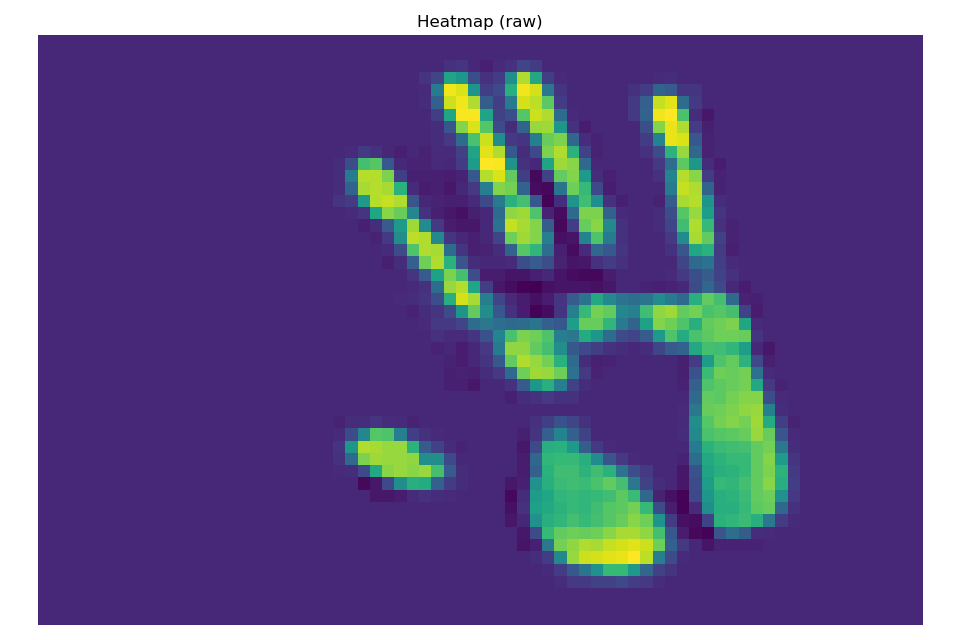

In [19]:
# visualize original heatmap
fig, ax = plt.subplots()
ax.set_title('Heatmap (raw)')
ax.axis('off')
ax.imshow(hm)
plt.show()

<IPython.core.display.Javascript object>


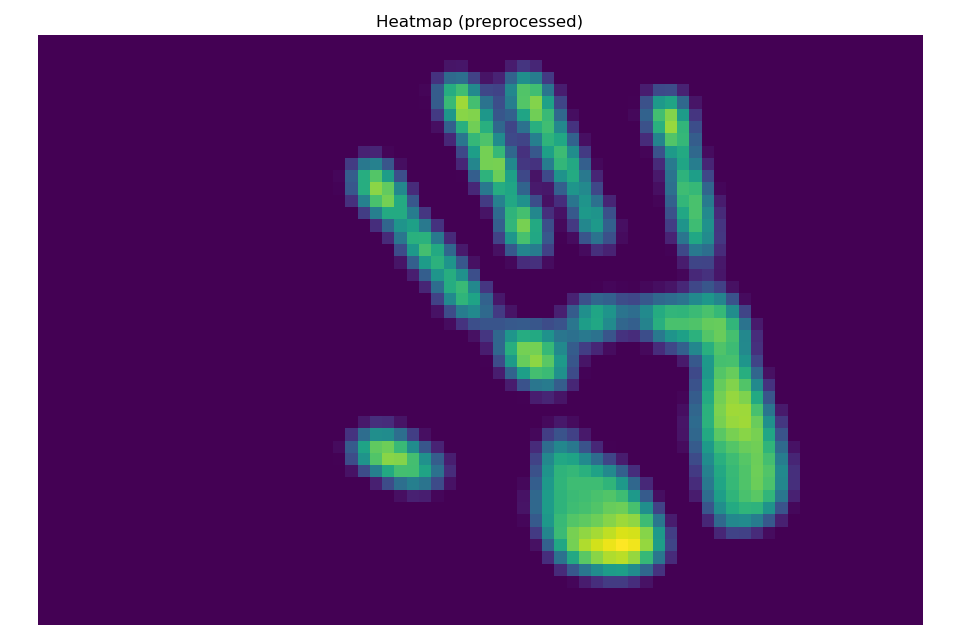

In [20]:
# visualize pre-processed heatmap
fig, ax = plt.subplots()
ax.set_title('Heatmap (preprocessed)')
ax.axis('off')
ax.imshow(hmpp)
plt.show()

<IPython.core.display.Javascript object>


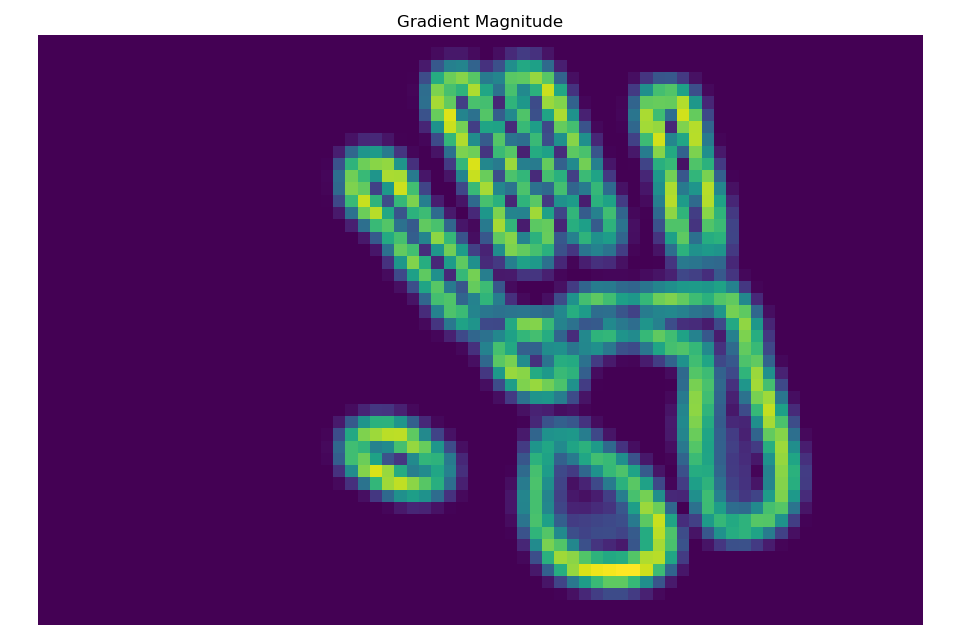

In [21]:
# visualize gradient magnitude
fig, ax = plt.subplots()
ax.set_title('Gradient Magnitude')
ax.axis('off')
ax.imshow(np.linalg.norm(g, axis=-1))
plt.show()

<IPython.core.display.Javascript object>


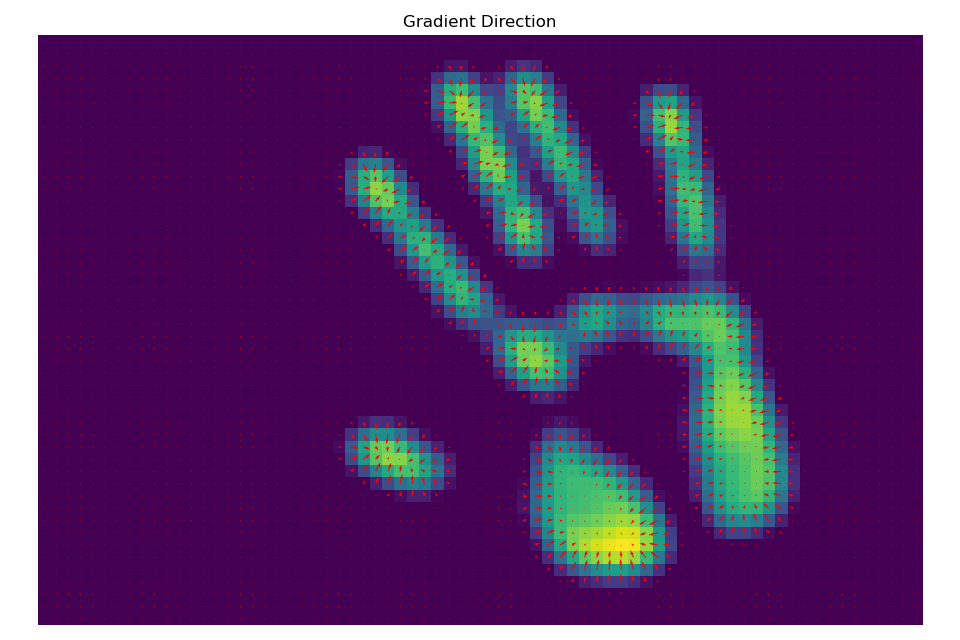

In [22]:
# visualize gradient direction (direction indicated by arrows, gradient magnitude indicated by length)
fig, ax = plt.subplots()
ax.set_title('Gradient Direction')
ax.axis('off')
ax.imshow(hmpp)
ax.quiver(g[:, :, 0], -g[:, :, 1], fc='r', ec='r', units='x', width=0.08, scale=0.8)
plt.show()

<IPython.core.display.Javascript object>


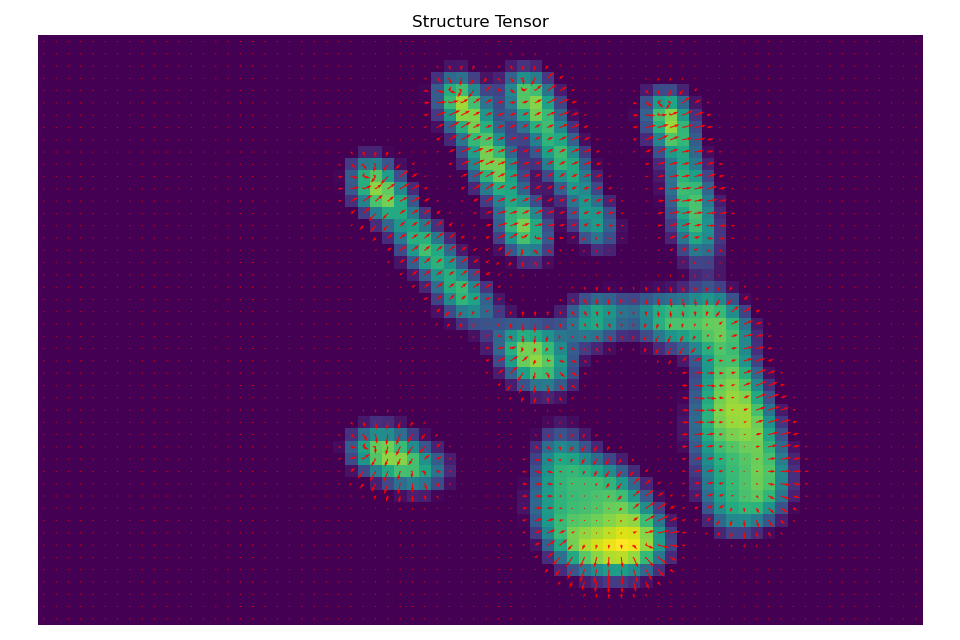

In [23]:
# visualize structure tensor, arrows indicate eigenvectors scaled by their respective eigenvalues
fig, ax = plt.subplots()
ax.set_title('Structure Tensor')
ax.axis('off')
ax.imshow(hmpp)
for i in range(2):
    _uv = evs_s[:, :, i, :] * ews_s[:, :, i, None]
    ax.quiver(_uv[:, :, 0], _uv[:, :, 1], fc='r', ec='r', units='x', width=0.08, scale=0.25)
plt.show()

<IPython.core.display.Javascript object>


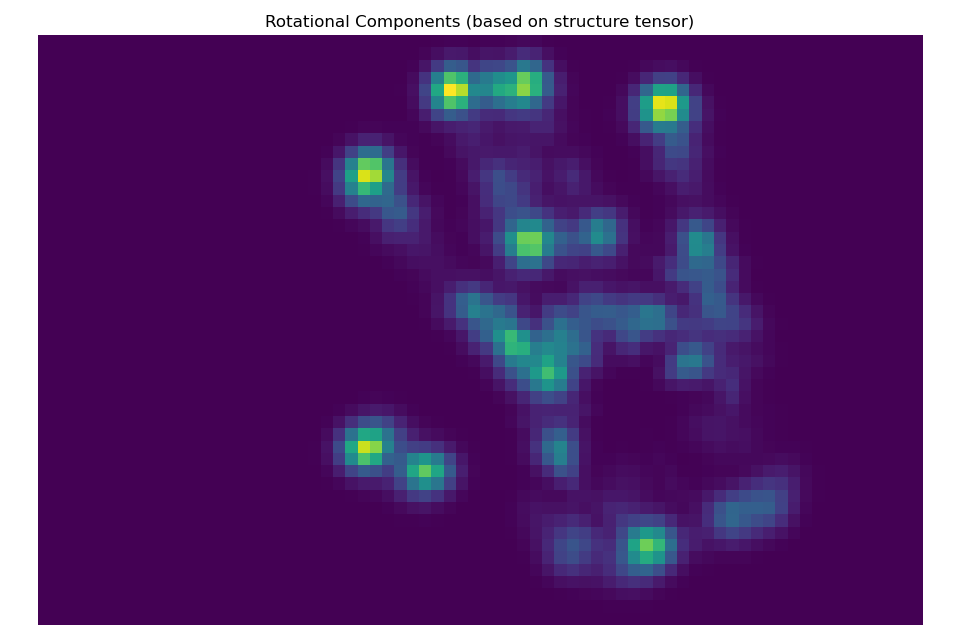

In [24]:
# visualize rotational structures (rot)
fig, ax = plt.subplots()
ax.set_title('Rotational Components (based on structure tensor)')
ax.axis('off')
ax.imshow(rot)
plt.show()

<IPython.core.display.Javascript object>


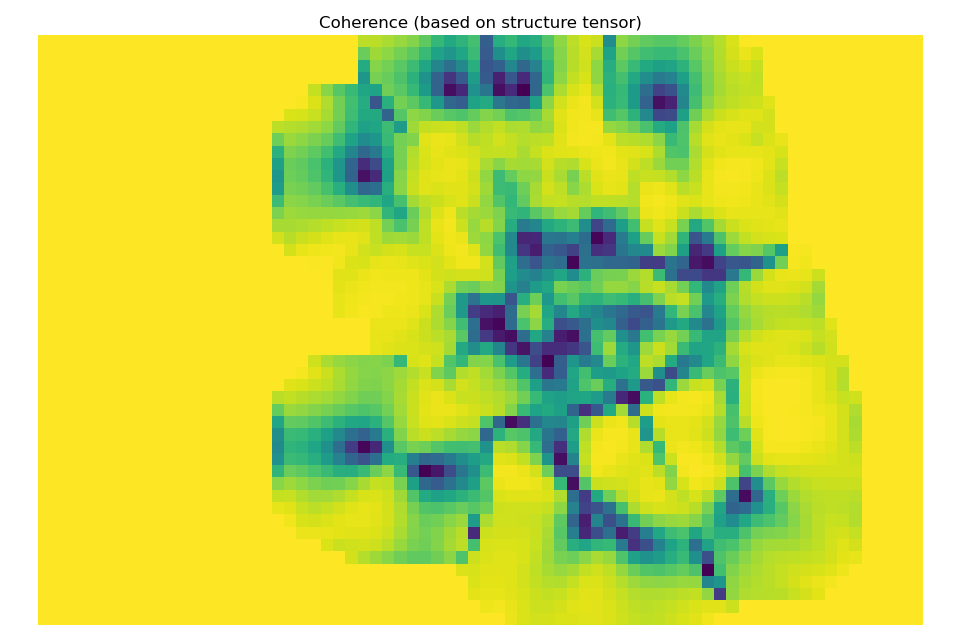

In [25]:
# visualize coherence (coh)
fig, ax = plt.subplots()
ax.set_title('Coherence (based on structure tensor)')
ax.axis('off')
ax.imshow(coherence)
plt.show()

<IPython.core.display.Javascript object>


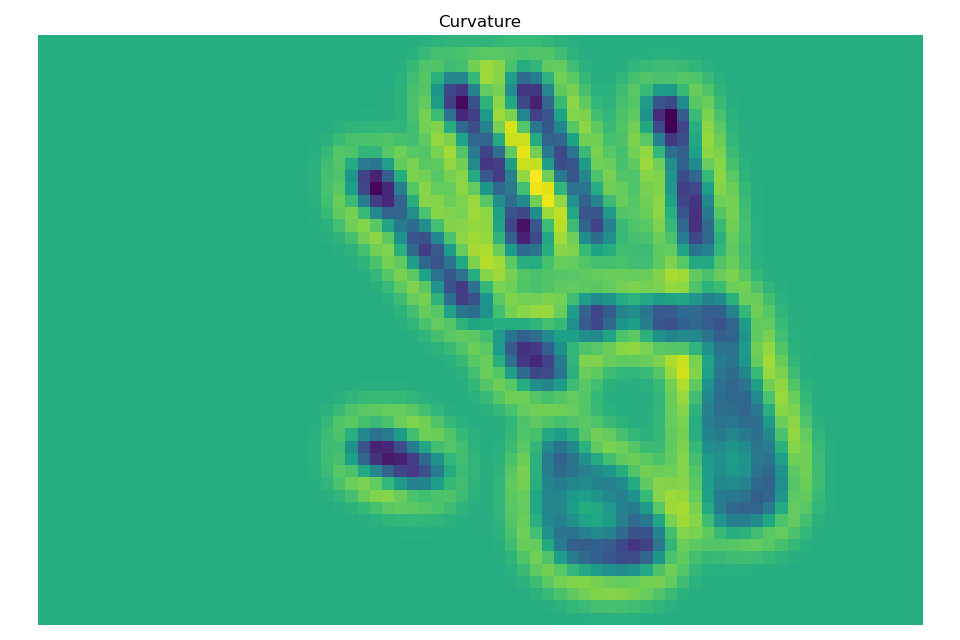

In [26]:
# visualize curvature (c)
fig, ax = plt.subplots()
ax.set_title('Curvature')
ax.axis('off')
ax.imshow(curv)
plt.show()

<IPython.core.display.Javascript object>


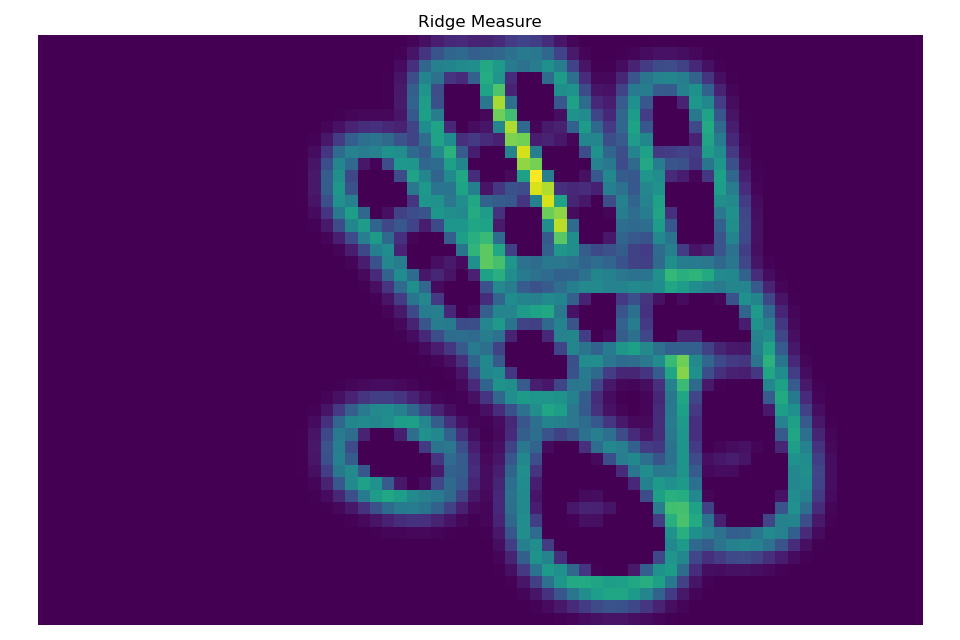

In [27]:
# visualize ridge measure (r)
fig, ax = plt.subplots()
ax.set_title('Ridge Measure')
ax.axis('off')
ax.imshow(ridge)
plt.show()

## Method

Now that we have an overview of some metrics and measures applied to actual input data (albeit expected to special and uncommon), we can lay out our plan forward:
The basic idea is to start off by detecting individual parts of the heatmap image, i.e. objects.
Next, we try to classify those into finger-tip/non-finger-tip (or Gaussian-like/non-Gaussian-like) and remove anything that doesn't work well with our Gaussian fitting model.

### Object Detection and Labeling

Remember that for object detection, we want to also separate connected components that may overlap in the input heatmap image.
This, specifically, is why we've looked at the ridge measure above.
Combined with the pre-processed heatmap image, this measure will be used to determine the connected components that make up this image by first deciding which pixels belong to objects (via what we will refer to as the objective measure), and then labeling those objects by analyzing the connections between individual pixels of which they are made up.

To compute the objective measure, we rely on a simple blending formula with one coefficient per input image/measure, i.e. $o = \omega_{h} \cdot h - \omega_{r} \cdot r$, where $h$ is the pre-processed heatmap, $r$ the ridge measure as defined above, and $\omega_{h}, \omega_{r} > 0$ their respective weights.
Note that we subtract the ridge measure here as we essentially want to downweigh the objective score for any pixel that is likely on the boundary between two components, i.e. on a ridge. Also note that this mixing function itself can be seen as parameter to be exchanged with arbitrarily complex parametrizations.

With this objective measure defined, we can then consider every pixel $x$ with a score over a certain threshold $\varrho < o(x)$ to be part of an object.

In [28]:
w_ridge, w_heat = 1.0, 1.0
th_obj = 0.0

objective = w_heat * hmpp - w_ridge * ridge
objects = objective > th_obj

<IPython.core.display.Javascript object>


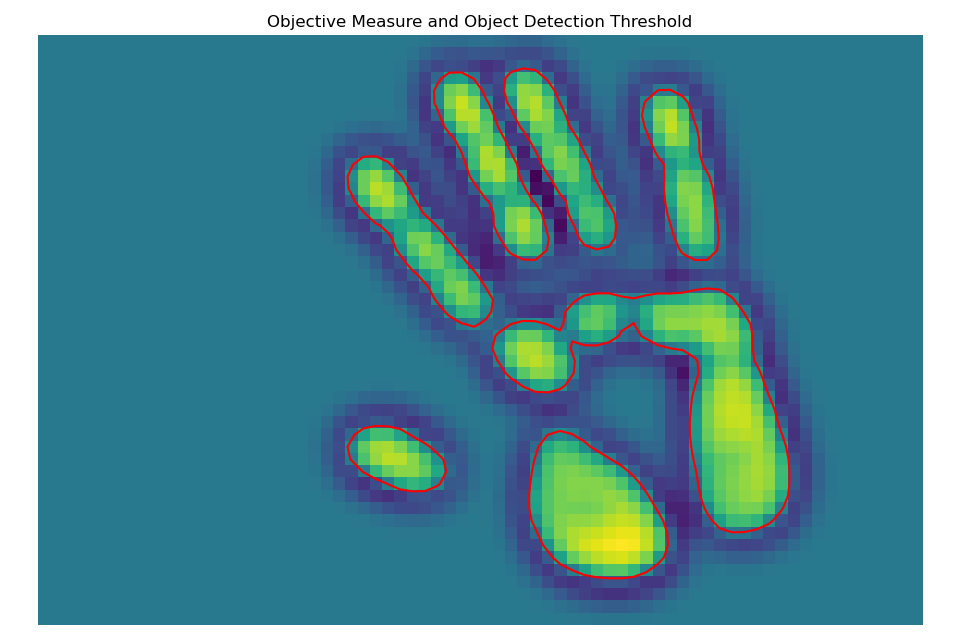

In [29]:
# visualize objective measure
fig, ax = plt.subplots()
ax.set_title('Objective Measure and Object Detection Threshold')
ax.axis('off')
ax.imshow(objective)
ax.contour(objective, levels=[th_obj], colors='red')
plt.show()

Visualizing the objective measure and the object detection threshold (resulting in the red outline of objects) shows us that this works fairly well and can separate objects that would be considered connected when looking at the pre-processed heatmap only (e.g. middle- and ring-finger).

As the above thresholding only gives us a binary classification (object vs. non-object), we now need to apply a labeling algorithm.
This will analyze the now binary image for connectedness and give all pixels a label that corresponds to their specific object.
Here, we can choose what we consider to be connected, essentially differentiating between 4- and 8-connected pixels.
For 4-connectedness, only top, bottom, left, and right neighbors will be considered to be part of the same object, assuming their objective measure is high enough for them to be considered part of any object in the first place, whereas top-left, top-right, bottom-left, and bottom-right pixels alone are not sufficient to determine this.
For 8-connectedness, all direct neighbor pixels (over the detection threshold) imply that the two specific pixels are part of the same object.

In [30]:
# labeling
structure_4 = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0],
])

structure_8 = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
])

labels, num_labels = scipy.ndimage.label(objects, structure_4)

<IPython.core.display.Javascript object>


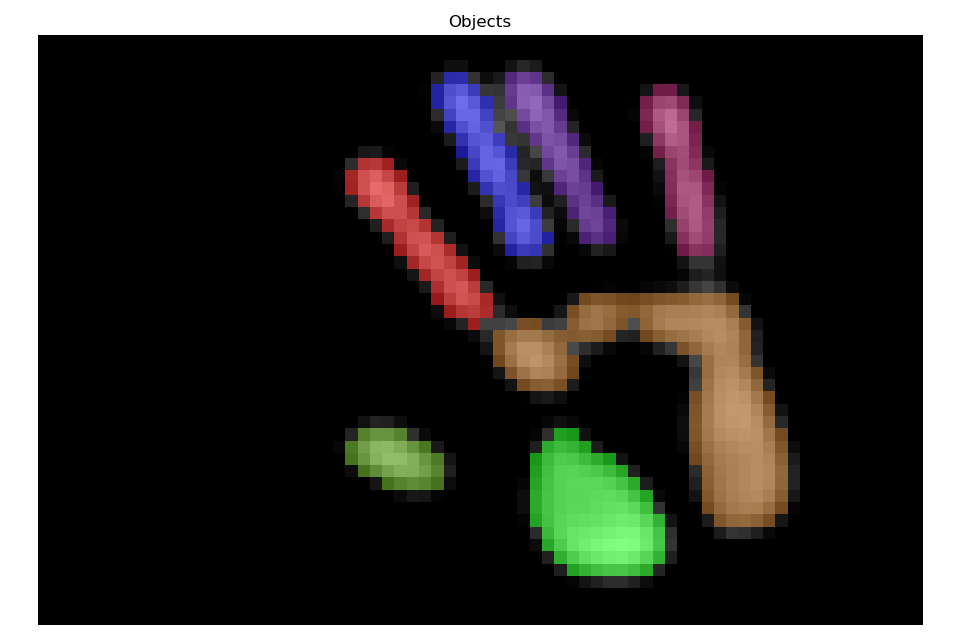

In [31]:
# visualize objects/segmentation with pre-processed heatmap as brackground
fig, ax = plt.subplots()
ax.set_title('Objects')
ax.axis('off')
ax.imshow(hmpp, cmap='gray')
ax.imshow(np.ma.masked_where(labels == 0, labels), alpha=0.5, cmap='brg')
plt.show()

### Decomposition

As indicated by the colors in the visualization above, we now know which pixel belongs to which object.
However, overlaying this labeling ontop of the pre-processed heatmap, we see that not all pixels have been labeled.
Specifically, pixels on the border between background or other components have been left out.
Ideally, we would also like to assign labels to those, however, as these pixels may represent overlapping areas, assigning a single label may not be possible.
Instead, we essentially need to assign labels and corresponding weights, such that the sum of the resulting decompositions obtained by multiplying said weights with the pre-processed heatmap yields a reconstruction of that heatmap.

A fairly simple idea for this is considering the pixels $x_c$ of the core components as identified above as parts with a weight of $w(x_c, l_c) = 1$ for the particular component $c$ and $w(x_c, l_p) = 0$ for any other component $p \neq c$.
We then compute the (non-normalized) weight $\tilde{w}(x, l)$ for any non-component pixel $x$ and label $l$ based on its distance $d(x, l)$ (either euclidean or, better, based on some measure) to the nearest pixel with that label.
After normalizing the weights, so that all weights at a pixel sum up to one ($w_l = \tilde{w}_l\,/\, \sum_k{\tilde{w}_k}$), we can compute the individual decompositions $h_l$ by multiplying the weight $w_l$ of the respective label $l$ with the pre-processed heatmap $h$, i.e. $h_l = w_l \cdot h$.
Note that this fulfills $h = \sum_l h_l \cdot w_l$.

To improve this process, we use a weighted distance transform.
Instead of simply considering the euclidean distance, we can, with that, compute distance weights based on the gradient and ridge measure (or other measures, e.g. alignment of walking direction with gradient may be better), where parts with higher gradient and ridge measure incur more cost.
This means that walking along a smooth path will incur less cost, thus expanding influence along e.g. slow declines, whereas walking over strong declines and increases incurs a higher cost, meaning we achieve a better separation along ridges, which, again, we assume separate different components.

To compute the non-normalized weights $\tilde{w}$, we rely on a Gaussian approach, i.e. $w_l(x) = \exp\left((-d(x, l)/\sigma\right)^2)$ with parameter $\sigma$, which should fit well with our assumption that finger-tips are (remotely) Gaussian shaped.

Note that in the code below, we combine several labels to reduce the number of decompositions.
For our ultimate goal, filtering out non-Gaussian-shaped components, we only need two decompositions: included and excluded components.

In [32]:
def generate_mask(hm, labels, include):
    mask = labels == 0

    for lbl in include:
        mask = np.logical_or(mask, labels == lbl)
    
    return np.logical_and(hm > 0, mask)


def generate_bin(labels, include):
    mask = np.full(labels.shape, True, dtype=np.bool)

    for lbl in include:
        mask = np.logical_and(mask, labels != lbl)
    
    return mask


def compute_distance_map(hm, labels, cost, include, sigma=1.0, cutoff=1e-10):
    b = generate_bin(labels, include)
    m = generate_mask(hm, labels, include)

    w = dip.GreyWeightedDistanceTransform(cost, b, m)
    w = np.exp(-(w / sigma)**2)
    w[w < cutoff] = 0

    return w


def compute_weights(hm, ews_s, ridge, labels, sets, c_ridge=9.0, c_grad=1.0, c_offs=0.1):
    cost = ridge * c_ridge + np.sum(np.abs(ews_s), axis=-1) * c_grad + c_offs

    weights = np.array([compute_distance_map(hm, labels, cost, s) for s in sets])
    total = np.sum(weights, axis=0)

    return np.divide(weights, total[None, :, :], out=np.zeros_like(weights), where=total != 0)

To test our approach, let's decompose the heatmap into three (somewhat arbitrary) parts:

In [33]:
set_a = set([1, 4, 6])
set_b = set([2, 3, 7])
set_c = set(range(1, num_labels + 1)) - set_a - set_b

ws = compute_weights(hmpp, ews_s, ridge, labels, [set_a, set_b, set_c])

<IPython.core.display.Javascript object>


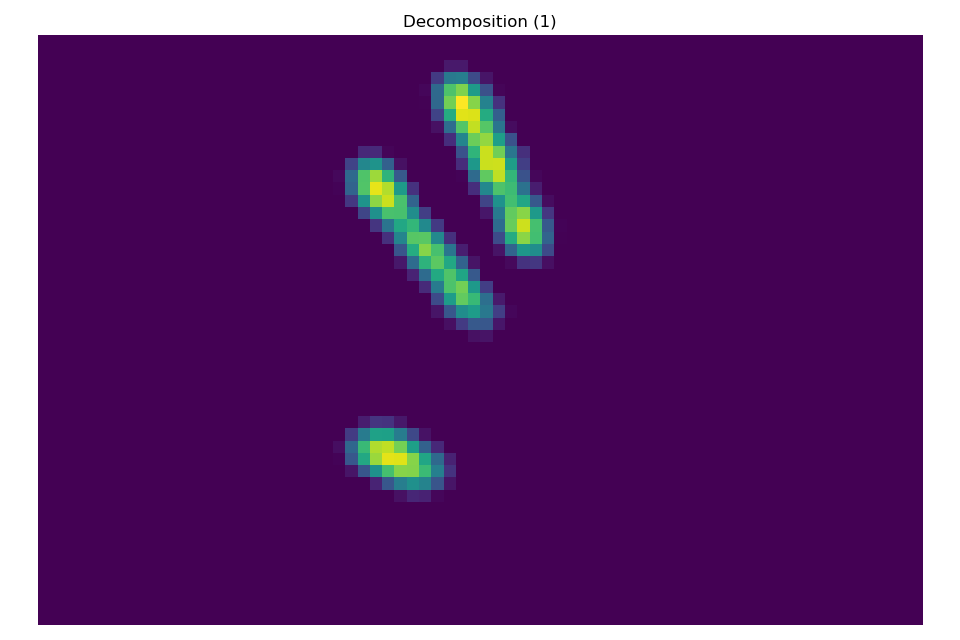

In [34]:
# visualize decomposition (part 1)
fig, ax = plt.subplots()
ax.set_title('Decomposition (1)')
ax.axis('off')
ax.imshow(ws[0, :, :]  * hmpp)
plt.show()

<IPython.core.display.Javascript object>


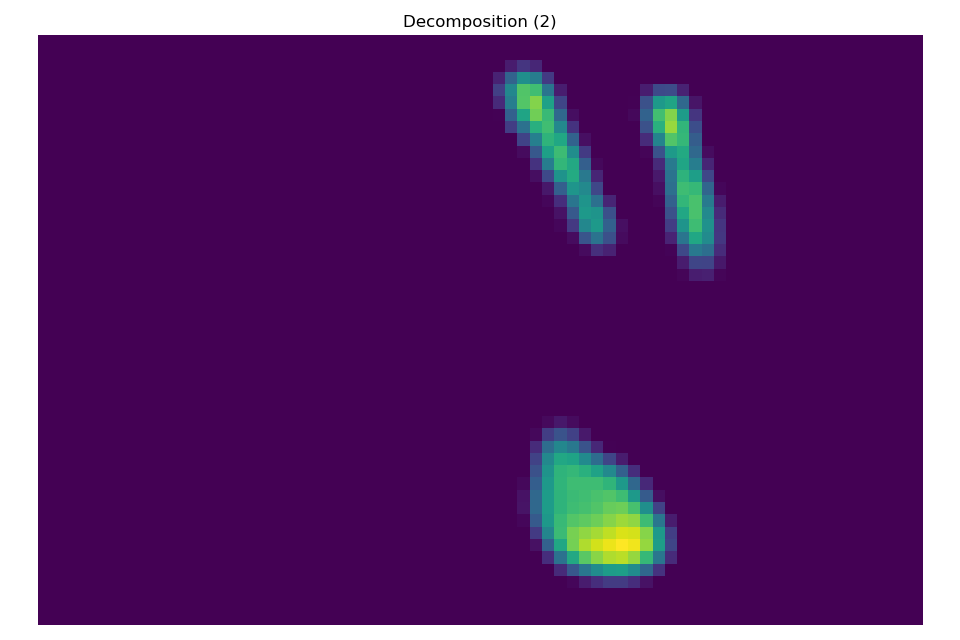

In [35]:
# visualize decomposition (part 2)
fig, ax = plt.subplots()
ax.set_title('Decomposition (2)')
ax.axis('off')
ax.imshow(ws[1, :, :]  * hmpp)
plt.show()

<IPython.core.display.Javascript object>


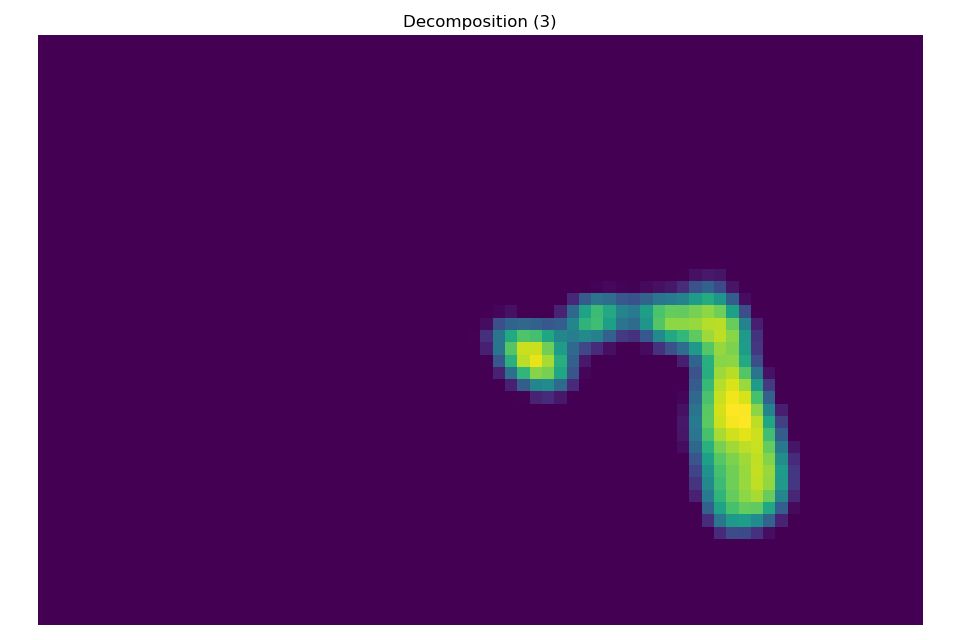

In [36]:
# visualize decomposition (part 3)
fig, ax = plt.subplots()
ax.set_title('Decomposition (3)')
ax.axis('off')
ax.imshow(ws[2, :, :] * hmpp)
plt.show()

To ensure that the result is sound, we can now look at the mean square reconstruction error:

In [37]:
np.sum((np.sum(ws * hmpp[None, :, :], axis=0) - hmpp)**2) / np.product(hmpp.shape)

1.7697720504046662e-37

### Classification

While we can now decompose our image into different, potentially overlapping, components, we still need to determine which components we want to include in the filtered heatmap, and which components we want to exclude from it.

TODO

In [38]:
rot = 1.0 - coherence

lbl_max = np.zeros(num_labels)
lbl_vol = np.zeros(num_labels)
lbl_rot = np.zeros(num_labels)

for x1, x2 in get_local_maximas(hmpp):
    lbl_max[labels[x1, x2] - 1] += 1

# ensure that we don't divide by zero
# instead set this to inf, causing the score to become zero and the component to be excluded
lbl_max[lbl_max == 0] = np.inf

for x2, x1 in itertools.product(range(labels.shape[1]), range(labels.shape[0])):
    if labels[x1, x2] == 0:
        continue
    
    lbl_vol[labels[x1, x2] - 1] += 1
    lbl_rot[labels[x1, x2] - 1] += rot[x1, x2]

# add epsilon to prevent division by zero
cscore = 100.0 * (lbl_rot / lbl_vol**2) * (1.0 / lbl_max) + np.finfo(np.float).eps

# equivalent to sigmoid(log(cscore)), use log to transform [0, +inf] to [-inf, +inf]
# cscore = 1.0 / (1.0 + (1.0 / cscore))
cscore = cscore / (1.0 + cscore)  # equivalent to the above
cscore

array([0.16813666, 0.16703346, 0.24280045, 0.14482464, 0.03496483,
       0.62656996, 0.265924  ])

<IPython.core.display.Javascript object>


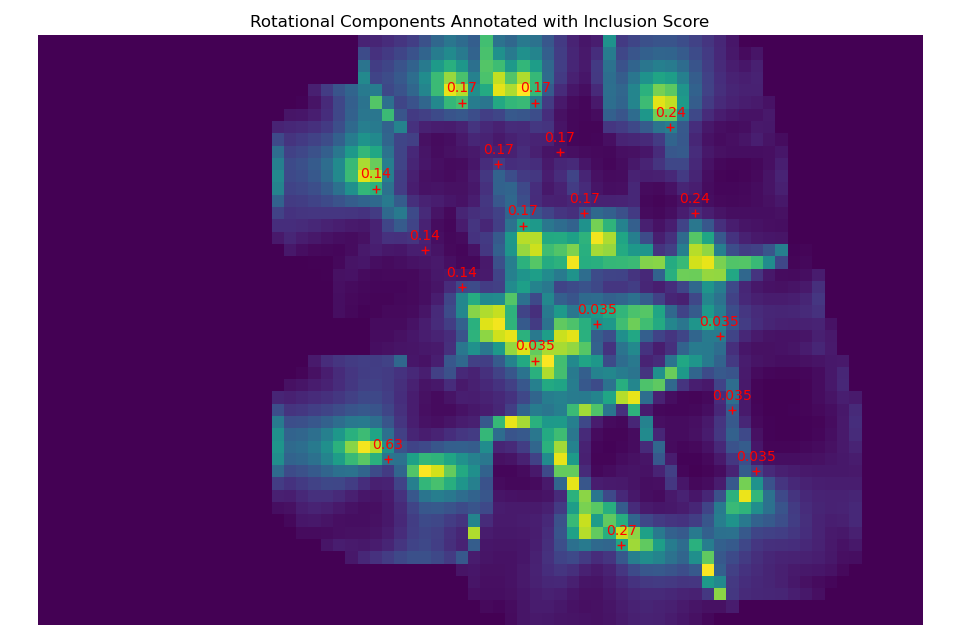

In [39]:
_ms = get_local_maximas(hmpp)

# visualize rotational structures
fig, ax = plt.subplots()
ax.set_title('Rotational Components Annotated with Inclusion Score')
ax.axis('off')
ax.imshow(rot)
ax.plot(_ms[:, 1], _ms[:, 0], 'b+', color='red')

for x1, x2 in _ms:
    ax.annotate(f"{cscore[labels[x1, x2] - 1]:.2}", (x2, x1), textcoords="offset points",
                xytext=(0, 7.5), ha='center', color='red')

plt.show()

<IPython.core.display.Javascript object>


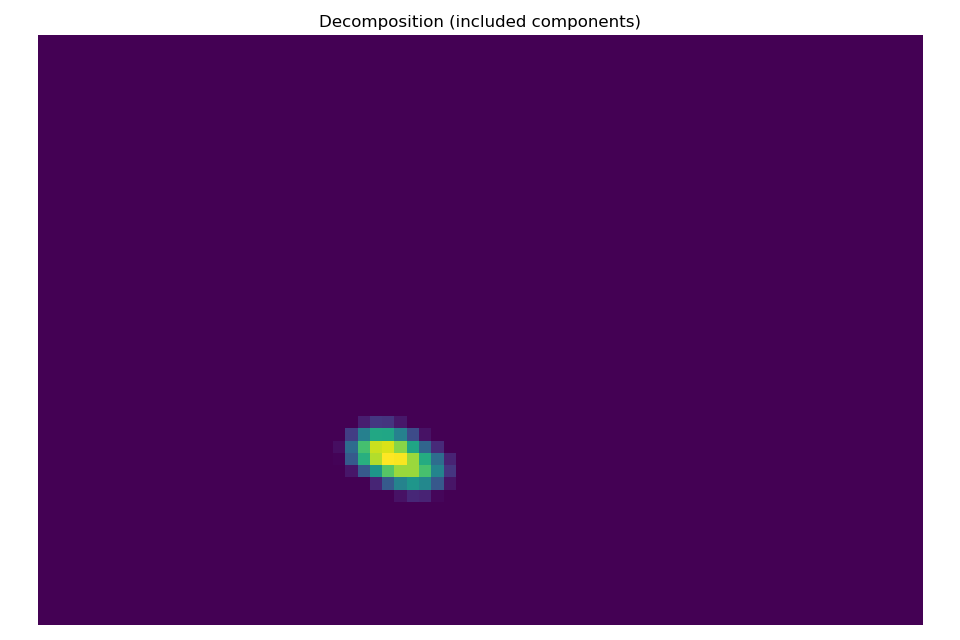

In [40]:
th_inc = 0.6

set_inc = set(lbl for lbl in range(1, num_labels + 1) if cscore[lbl - 1] > th_inc)
set_exc = set(range(1, num_labels + 1)) - set_inc

ws = compute_weights(hmpp, g, ridge, labels, [set_inc, set_exc])

# visualize decomposition (included)
fig, ax = plt.subplots()
ax.set_title('Decomposition (included components)')
ax.axis('off')
ax.imshow(ws[0, :, :] * hmpp)
plt.show()

<IPython.core.display.Javascript object>


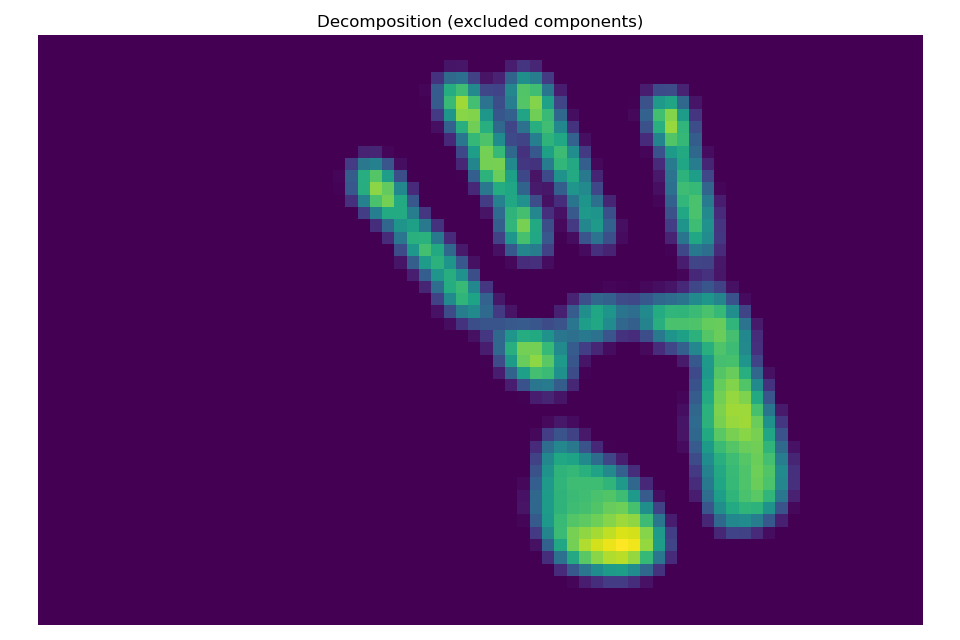

In [41]:
# visualize decomposition (excluded)
fig, ax = plt.subplots()
ax.set_title('Decomposition (excluded components)')
ax.axis('off')
ax.imshow(ws[1, :, :] * hmpp)
plt.show()